In [1]:
import pandas as pd
import requests

# Wikipedia URL
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# Identify yourself per Wikipedia's guidelines
email = "mheat21@byu.edu"
ua = f"STAT386-class-scraper/1.0 (+{email})"

# Fetch HTML with headers
r = requests.get(url, headers={"User-Agent": ua, "From": email}, timeout=15)
r.raise_for_status()

# Parse tables from the *HTML content*, not the URL
tables = pd.read_html(r.text)

# The first table is the S&P 500 companies list
wiki_df = tables[0]

# Keep and rename key columns
wiki_df = wiki_df[['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry']]
wiki_df.columns = ['Ticker', 'Company', 'Sector', 'SubIndustry']

# Use Wikipedia df and fix mismatched tickers
tickers = wiki_df['Ticker'].replace({'BRK.B': 'BRK-B', 'BF.B': 'BF-B'}).tolist()

print(wiki_df.shape)
print(wiki_df.head())


(503, 4)
  Ticker              Company                  Sector  \
0    MMM                   3M             Industrials   
1    AOS          A. O. Smith             Industrials   
2    ABT  Abbott Laboratories             Health Care   
3   ABBV               AbbVie             Health Care   
4    ACN            Accenture  Information Technology   

                      SubIndustry  
0        Industrial Conglomerates  
1               Building Products  
2           Health Care Equipment  
3                   Biotechnology  
4  IT Consulting & Other Services  


/var/folders/l9/dtywcq4x0_n3zd8mjfr26ttm0000gn/T/ipykernel_27067/641208208.py:16: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(r.text)


In [2]:
import yfinance as yf
from datetime import datetime, timedelta

end = datetime.today()
start = end - timedelta(days=365)
data = yf.download(tickers, start=start, end=end, group_by='ticker', progress=False)


/var/folders/l9/dtywcq4x0_n3zd8mjfr26ttm0000gn/T/ipykernel_27067/2796067995.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start, end=end, group_by='ticker', progress=False)


In [3]:
data_flat = pd.DataFrame()
for ticker in tickers:
    if ticker in data:
        df = data[ticker].copy()
        df.columns = [f"{ticker}_{col}" for col in df.columns]
    if data_flat.empty:
        data_flat = df
    else:
        data_flat = pd.concat([data_flat, df], axis=1)
else:
    print(f"No data for {ticker}")

No data for ZTS


In [4]:
metrics = []

for ticker in tickers:
    col_name = f"{ticker}_Close"
    if col_name in data_flat:
        close = data_flat[col_name]
        daily_return = close.pct_change()
        pct_change_1y = (close.iloc[-1] - close.iloc[0]) / close.iloc[0] * 100
        volatility = daily_return.std() * (252 ** 0.5) * 100
        avg_return = daily_return.mean() * 252 * 100
        max_drawdown = ((close.cummax() - close) / close.cummax()).max() * 100

        metrics.append({
            'Ticker': ticker,
            '1Y_Change(%)': pct_change_1y,
            'Volatility(%)': volatility,
            'AvgAnnualReturn(%)': avg_return,
            'MaxDrawdown(%)': max_drawdown
        })
else:
    print(f"Data missing for {ticker}")

perf_df = pd.DataFrame(metrics)

Data missing for ZTS


In [5]:
merged_df = wiki_df.merge(perf_df, on='Ticker', how='left')
print(merged_df.head())

  Ticker              Company                  Sector  \
0    MMM                   3M             Industrials   
1    AOS          A. O. Smith             Industrials   
2    ABT  Abbott Laboratories             Health Care   
3   ABBV               AbbVie             Health Care   
4    ACN            Accenture  Information Technology   

                      SubIndustry  1Y_Change(%)  Volatility(%)  \
0        Industrial Conglomerates     25.582990      29.673522   
1               Building Products    -11.969194      24.454848   
2           Health Care Equipment     10.422882      21.452919   
3                   Biotechnology     13.061136      28.846938   
4  IT Consulting & Other Services    -32.137831      28.279164   

   AvgAnnualReturn(%)  MaxDrawdown(%)  
0           27.528418       18.714543  
1           -9.969601       21.172245  
2           12.389165       13.270805  
3           16.711912       20.736387  
4          -35.357239       41.021444  


In [ ]:
# Drop rows where we didn’t get Yahoo data
clean_df = merged_df.dropna(subset=['1Y_Change(%)'])

# Sort by 1-year percent change descending
merged_df = clean_df.sort_values(
    by=['1Y_Change(%)', 'AvgAnnualReturn(%)'], ascending=[False, False]
)

# Check the top 10
print(merged_df.head(10))

    Ticker                 Company                  Sector  \
398   HOOD       Robinhood Markets              Financials   
357   PLTR   Palantir Technologies  Information Technology   
490    WDC         Western Digital  Information Technology   
408    STX      Seagate Technology  Information Technology   
40     APP                AppLovin  Information Technology   
483    WBD  Warner Bros. Discovery  Communication Services   
313     MU       Micron Technology  Information Technology   
280   LRCX            Lam Research  Information Technology   
72    AVGO                Broadcom  Information Technology   
434    TPR          Tapestry, Inc.  Consumer Discretionary   

                                    SubIndustry  1Y_Change(%)  Volatility(%)  \
398              Investment Banking & Brokerage    332.833785      74.579773   
357                        Application Software    213.260558      68.823068   
490  Technology Hardware, Storage & Peripherals    208.203474      52.523962 

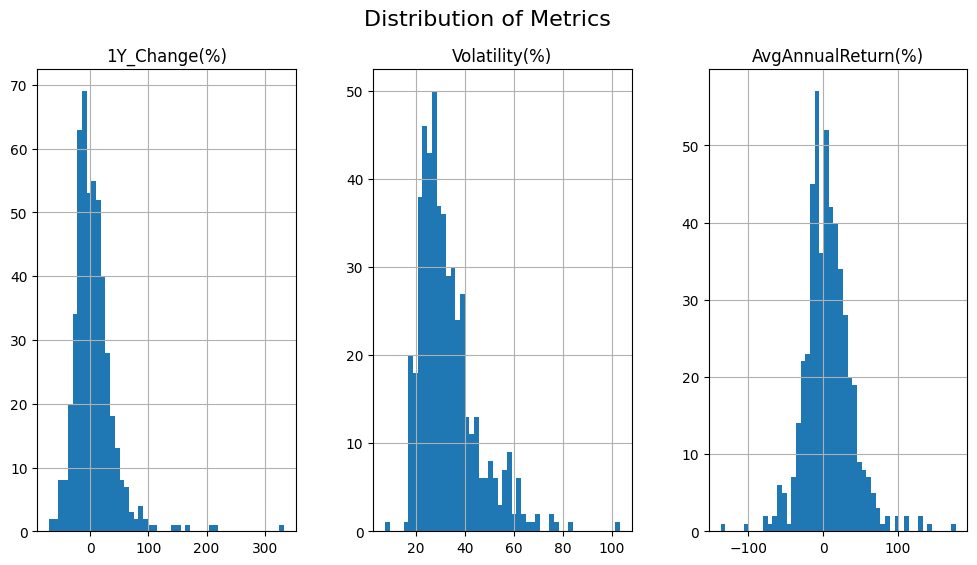

In [8]:
# EDA 
import matplotlib.pyplot as plt

# Plot histogram for selected columns
cols_to_plot = ['1Y_Change(%)', 'Volatility(%)', 'AvgAnnualReturn(%)']
merged_df[cols_to_plot].hist(bins=50, figsize=(12,6), layout=(1,3))
plt.suptitle('Distribution of Metrics', fontsize=16)
plt.show()

In [9]:
merged_df.describe()

,1Y_Change(%),Volatility(%),AvgAnnualReturn(%),MaxDrawdown(%)
count,499.000000,501.000000,501.000000,501.000000
mean,5.774609,33.008370,6.763807,28.445721
std,35.895201,11.946747,31.842728,11.609342
min,-70.493607,7.263224,-136.461271,5.810692
25%,-15.203975,24.591070,-11.915824,20.455792
50%,0.907385,30.101173,4.826374,27.327944
75%,21.250825,38.249707,23.879211,35.064664
max,332.833785,103.223698,176.781013,74.082172


<Axes: xlabel='Volatility(%)', ylabel='1Y_Change(%)'>

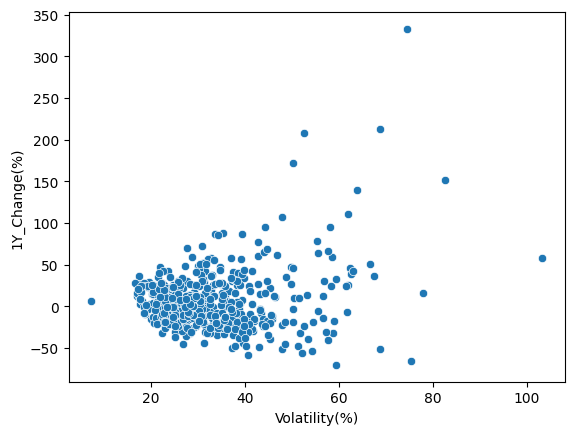

In [10]:
import seaborn as sns
sns.scatterplot(data=merged_df, x='Volatility(%)', y='1Y_Change(%)')

In [11]:
merged_df.sort_values('1Y_Change(%)', ascending=False).head(10)
merged_df.sort_values('1Y_Change(%)').head(10)

,Ticker,Company,Sector,SubIndustry,1Y_Change(%),Volatility(%),AvgAnnualReturn(%),MaxDrawdown(%)
196,FI,Fiserv,Financials,Transaction & Payment Processing Services,-70.493607,59.375849,-101.340688,74.082172
447,TTD,Trade Desk (The),Communication Services,Advertising,-65.366331,75.319273,-75.212627,68.511216
205,IT,Gartner,Information Technology,IT Consulting & Other Services,-58.124826,40.686953,-79.157200,59.046756
318,MOH,Molina Healthcare,Health Care,Managed Health Care,-56.433417,52.157008,-69.890893,58.376740
139,DECK,Deckers Brands,Consumer Discretionary,Footwear,-53.420101,54.359620,-62.053988,64.349424
316,MRNA,Moderna,Health Care,Biotechnology,-51.610977,68.696187,-50.071641,53.241844
153,DOW,Dow Inc.,Materials,Commodity Chemicals,-51.111823,47.923631,-61.059661,54.736178
14,ARE,Alexandria Real Estate Equities,Real Estate,Office REITs,-50.283733,37.306880,-63.654014,50.423235
58,BAX,Baxter International,Health Care,Health Care Equipment,-48.974941,42.974266,-58.524149,50.324133
293,LULU,Lululemon Athletica,Consumer Discretionary,"Apparel, Accessories & Luxury Goods",-48.128763,51.290440,-52.988426,62.040556


In [13]:
merged_df.to_csv("sp500_merged.csv", index=False)